# Hardness properties of a polycrystal
This notebook and the accompanying code demonstrates how to use the Graph Nets library to learn to predict the hardness map of a polycrystal ([Karimi et al. Scripta Materialia, 234:115559, 2023](https://doi.org/10.1016/j.scriptamat.2023.115559)).

The network is trained to predict the load-depth curves of nanoindented grains in steel. 

Upon training, the network's prediction ability is illustrated by comparing its output to the true hardness of the material.

<img src="workFlow.jpg" width="800"/>

# Copyright Notice

© 2023 **Kamran Karimi**. All rights reserved.

This notebook is licensed under the [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

---

## Contact Information

For any inquiries or further information, please contact:

- **Email:** [kamran.karimi@ncbj.gov.pl](mailto:kamran.karimni@ncbj.gov.pl)

Feel free to reach out with any questions or feedback.

# Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

In [1]:
install_graph_nets_library = "No"  #param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library and dependencies:")
  print("Output message from command:\n")
  !pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
else:
  print("Skipping installation of Graph Nets library")

Skipping installation of Graph Nets library


# Load configuration file & libraries

In [2]:
import sys
import os
import numpy as np
import pandas as pd

#--- plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
matplotlib.rcParams['text.usetex'] = True 

#--- interpolation  
from scipy.interpolate import Rbf
from scipy.stats import zscore

from sklearn.metrics import mean_squared_error


import sonnet as snt

import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

#--- graph nets
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_tf
from graph_nets import utils_np

import warnings
warnings.filterwarnings('ignore')

Here is the implementation of the graph net model in tensorflow.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


NUM_LAYERS       = 2  # Hard-code number of layers in the edge/node/global models.
LATENT_SIZE      = 16  # Hard-code latent layer sizes for demos.

GLOBAL_MODEL_FN=lambda: lambda x: x
  
NODE_NUM_LAYERS  = 2  # Hard-code number of layers in the edge/node/global models.
NODE_LATENT_SIZE = 8  # Hard-code latent layer sizes for demos.
EDGE_NUM_LAYERS  = 2  # Hard-code number of layers in the edge/node/global models.
EDGE_LATENT_SIZE = 8  # Hard-code latent layer sizes for demos.
GLOB_NUM_LAYERS  = 2  # Hard-code number of layers in the edge/node/global models.
GLOB_LATENT_SIZE = 32  # Hard-code latent layer sizes for demos.

ACT_FINAL        = False

def make_mlp_model():
  """Instantiates a new MLP, followed by LayerNorm.
  The parameters of each new MLP are not shared with others generated by
  this function.
  Returns:
    A Sonnet module 
  """
  return snt.Sequential([
      snt.nets.MLP([LATENT_SIZE] * NUM_LAYERS, activate_final=ACT_FINAL, activation=tf.keras.activations.tanh), #False, activation=tf.keras.activations.tanh),
      snt.LayerNorm()
  ])


def make_mlp_model_edge():
  """Instantiates a new MLP, followed by LayerNorm.
  The parameters of each new MLP are not shared with others generated by
  this function.
  Returns:
    A Sonnet module 
  """
  return snt.Sequential([
      snt.nets.MLP([EDGE_LATENT_SIZE] * EDGE_NUM_LAYERS, activate_final=ACT_FINAL, activation=tf.keras.activations.tanh), #False, activation=tf.keras.activations.tanh),
      snt.LayerNorm()
  ])

def make_mlp_model_node():
  """Instantiates a new MLP, followed by LayerNorm.
  The parameters of each new MLP are not shared with others generated by
  this function.
  Returns:
    A Sonnet module 
  """
  return snt.Sequential([
      snt.nets.MLP([NODE_LATENT_SIZE] * NODE_NUM_LAYERS, activate_final=ACT_FINAL, activation=tf.keras.activations.tanh), #False, activation=tf.keras.activations.tanh),
      snt.LayerNorm()
  ])

def make_mlp_model_global():
  """Instantiates a new MLP, followed by LayerNorm.
  The parameters of each new MLP are not shared with others generated by
  this function.
  Returns:
    A Sonnet module 
  """
  return snt.Sequential([
      snt.nets.MLP([GLOB_LATENT_SIZE] * GLOB_NUM_LAYERS, activate_final=ACT_FINAL, activation=tf.keras.activations.tanh), #False, activation=tf.keras.activations.tanh),
      snt.LayerNorm()
  ])

class MLPGraphIndependent(snt.AbstractModule):
  """GraphIndependent with MLP edge, node, and global models."""

  def __init__(self, name="MLPGraphIndependent"):
    super(MLPGraphIndependent, self).__init__(name=name)
    with self._enter_variable_scope():
      self._network = modules.GraphIndependent(
          edge_model_fn=make_mlp_model_edge,
          node_model_fn=make_mlp_model_node,
          global_model_fn=make_mlp_model_global)

  def _build(self, inputs):
    return self._network(inputs)


class MLPGraphNetwork(snt.AbstractModule):
  """GraphNetwork with MLP edge, node, and global models."""

  def __init__(self, name="MLPGraphNetwork"):
    super(MLPGraphNetwork, self).__init__(name=name)
    with self._enter_variable_scope():
      self._network = modules.GraphNetwork(edge_model_fn=make_mlp_model_edge, node_model_fn=make_mlp_model_node,
                                           global_model_fn=make_mlp_model_global)

  def _build(self, inputs):
    return self._network(inputs)


class EncodeProcessDecode(snt.AbstractModule):
  """Full encode-process-decode model.
  The model we explore includes three components:
  - An "Encoder" graph net, which independently encodes the edge, node, and
    global attributes (does not compute relations etc.).
  - A "Core" graph net, which performs N rounds of processing (message-passing)
    steps. The input to the Core is the concatenation of the Encoder's output
    and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
    the processing step).
  - A "Decoder" graph net, which independently decodes the edge, node, and
    global attributes (does not compute relations etc.), on each message-passing
    step.
                      Hidden(t)   Hidden(t+1)
                         |            ^
            *---------*  |  *------*  |  *---------*
            |         |  |  |      |  |  |         |
  Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
            |         |---->|      |     |         |
            *---------*     *------*     *---------*
  """

  def __init__(self,
               edge_output_size=None,
               node_output_size=None,
               global_output_size=None,
               name="EncodeProcessDecode"):
    super(EncodeProcessDecode, self).__init__(name=name)
    self._encoder = MLPGraphIndependent()
    self._core = MLPGraphNetwork()
    self._decoder = MLPGraphIndependent()
    # Transforms the outputs into the appropriate shapes.
    if edge_output_size is None:
      edge_fn = None
    else:
      edge_fn = lambda: snt.Linear(edge_output_size, name="edge_output")
    if node_output_size is None:
      node_fn = None
    else:
      node_fn = lambda: snt.Linear(node_output_size, name="node_output")
    if global_output_size is None:
      global_fn = None
    else:
      global_fn = lambda: snt.Linear(global_output_size, name="global_output")
    with self._enter_variable_scope():
      self._output_transform = modules.GraphIndependent(edge_fn, node_fn,
                                                        global_fn)

  def _build(self, input_op, num_processing_steps):
    latent = self._encoder(input_op)
    latent0 = latent

    latent_ops = [latent]
    output_ops = []
    for _ in range(num_processing_steps):
      core_input = utils_tf.concat([latent0, latent], axis=1)
      latent = self._core(core_input)
      latent_ops.append(latent)
      decoded_op = self._decoder(latent)
      output_ops.append(self._output_transform(decoded_op))
    return output_ops, latent_ops





# Helper functions
Let's define some utility functions for plotting and data processing.

In [4]:
class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

def PutMinorTicks(ax, LOGY=None,LOGX=None, nevery_x=1,nevery_y=1):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if LOGY:
        #--- add major yticks
        ymin   = np.ceil(np.log10(ax.axis()[2]))
        ymax   = np.floor(np.log10(ax.axis()[3]))
        nbin   = ymax - ymin
        ax.set_yticks(10**np.arange(ymin,ymax+nevery_y,nevery_y))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if LOGX:
        #--- add major yticks
        ymin   = np.ceil(np.log10(ax.axis()[0]))
        ymax   = np.floor(np.log10(ax.axis()[1]))
        nbin   = ymax - ymin
        ax.set_xticks(10**np.arange(ymin,ymax+nevery_x,nevery_x))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

        

def PltErr( xdata, ydata, 
            yerr = None,
            xstr = '',
            ystr = '',
            Plot = True,
            **kwargs
            ):
    fontsize = kwargs['fontsize'] if 'fontsize' in kwargs else 20
    if not 'ax' in kwargs:
        fig  = plt.figure( figsize = (4,4) if 'figsize' not in kwargs else kwargs['figsize'] )
        ax   = fig.add_subplot(111)
        ax.markerss=['o','s','D','^','<','>','v']
    else:
        ax   = kwargs['ax']

        if 'twinx' in kwargs and kwargs['twinx']:
            ax = kwargs['ax'].twinx()
    #--- setting   
    ax.set_xlabel(xstr,fontsize=fontsize)
    ax.set_ylabel(ystr,fontsize=fontsize)
    ax.tick_params(labelsize=fontsize,which='both',axis='both', top=True, right=True)
    #
    xerr = kwargs['xerr'] if 'xerr' in kwargs else None 
#
    if 'attrs' in kwargs:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, **kwargs['attrs'])
        if 'fill_between' in kwargs and kwargs['fill_between']:
            ax.fill_between(xdata, ydata-yerr, ydata+yerr)
    else:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr,
                    fmt=kwargs['fmt'] if 'fmt' in kwargs else '-o',
                    label=kwargs['label'] if 'label' in kwargs else '',
                    markevery=kwargs['markevery'] if 'markevery' in kwargs else 1,
                    markersize=kwargs['markersize'] if 'markersize' in kwargs else 10,
                    marker=kwargs['marker'] if 'marker' in kwargs else 'o', #ax.markerss[(ax.count)%7],
                   )

    #--- plot
    if 'ylim' in kwargs:
        ylim = kwargs['ylim'] 
        ax.set_ylim(ylim)
    if 'xlim' in kwargs:
        xlim = kwargs['xlim'] 
        ax.set_xlim(xlim)
    #
    if 'xscale' in kwargs: 
        ax.set_xscale(kwargs['xscale'])
    if 'yscale' in kwargs: 
        ax.set_yscale(kwargs['yscale'])
    #
    if 'xticks' in kwargs:
        ax.set_xticks(list(map(float,kwargs['xticks'][1])))
#        ax.set_xticklabels(list(map(lambda x:'$%s$'%x,kwargs['xticks'][0])))
        ax.set_xticklabels(kwargs['xticks'][0])
    #
    if 'yticks' in kwargs:
        ax.set_yticks(list(map(float,kwargs['yticks'][1])))
        ax.set_yticklabels(list(map(lambda x:'$%s$'%x,kwargs['yticks'][0])))
        
    #
    LOGY      = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX      = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    ndecade_x = kwargs['ndecade_x'] if 'ndecade_x' in kwargs else 1
    ndecade_y = kwargs['ndecade_y'] if 'ndecade_y' in kwargs else 1
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY,nevery_x=ndecade_x,nevery_y=ndecade_y)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'],LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs:
        plt.legend(**kwargs['legend'])
	#
    if 'halfopen' in kwargs and kwargs['halfopen']:
        ax.spines['right'].set_visible(False) #--- half open
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

    if 'set_title' in kwargs: #Plot:
        ax.set_title(kwargs['set_title'],fontsize=fontsize )
    if 'title' in kwargs: #Plot:
        plt.savefig(kwargs['title'],dpi=300 if not 'dpi' in kwargs else kwargs['dpi'],bbox_inches='tight', 
                    pad_inches=0.0)
    if Plot:
        plt.show()
    return ax


def FilterDataFrame(test_data_grains,key='id',val=[1,2,3],out='index'):
    tmp = pd.DataFrame(np.c_[np.arange(test_data_grains.shape[0]),test_data_grains],columns=[out]+list(test_data_grains.keys()))
    return np.c_[tmp.set_index(key,drop=True,append=False).loc[val][out]].flatten().astype(int)

    
def base_graph(df_attributes, 
                df_pairwise_attributes, 
                disps,
                forces,
                attributes
              ):
    """
    This function loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target       here the array containing the nodal target data
        weight       if needed, a weight parameter given for the (training) nodes
    """
    
    
    positions = np.c_[df_attributes.apply(zscore)[attributes],zscore(forces)].tolist()
    edges     = np.c_[df_pairwise_attributes[['misOrientationAngle(deg)','boundaryLength(micron)']]].tolist()
    
    grain_i_indices = FilterDataFrame(df_attributes,key='#grainID',val=df_pairwise_attributes['#grain_i_ID'],out='index')
    grain_j_indices = FilterDataFrame(df_attributes,key='#grainID',val=df_pairwise_attributes['grain_j_ID'],out='index')

    receivers = list(grain_j_indices)
    senders   = list(grain_i_indices) 
    
    target = list(map(lambda x:list(x),disps))
    weight = list(np.ones(df_attributes.shape[0]))

    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },target, weight 

def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op

# Dataset
Our dataset consists of a collection of grain-level load-depth curves corresponding to
nano-indentation tests performed on a polycrystalline steel. 
The dataset is organized within the `data/loadCurves` directory with relevant data files labeled as `GrainID_${grain_id}_LoadID${load_id}_IndentLabel_${indent_label}.txt`. 
Here `grain_id` denotes grain id and `load_id=0...10` corresponds to the maximum indentation load used in each experimental set with `fmax = 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5, 7, 10 mN`.
The variable `indent_label=1...15` is associated with the same fmax but at different indentation points as labeled in the EBSD map below.

<img src="ebsd.png" width="800"/>

The raw data set (including the load-depth curves and EBSD file) can be accessed through the following link: [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7975920.svg)](https://doi.org/10.5281/zenodo.7975920)


These files include two columns representing the indentation depth (nm) and force (mN) measurements. 

In [5]:
list_loadCurves        = os.listdir('data/loadCurves')
loadCurves             = {item:np.loadtxt( 'data/loadCurves/%s'%item ) for item in list_loadCurves}

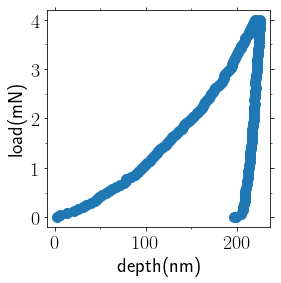

<AxesSubplot:xlabel='depth(nm)', ylabel='load(mN)'>

In [6]:
load_depth = loadCurves['loadDepth_GrainID_211_LoadID4_IndentLabel_1.txt']
PltErr(load_depth[:,0],load_depth[:,1],
      xstr='depth(nm)',ystr='load(mN)')

The grains' attributes are included in `data/attributes.txt` and `data/pairwise_attributes.txt`.

In [7]:
df_attributes          = pd.read_csv('data/attributes.txt',sep=' ')
df_pairwise_attributes = pd.read_csv('data/pairwise_attributes.txt',sep=' ')

df_attributes.shape

(5364, 16)

In [8]:
df_attributes.head()

,#grainID,x,y,area,perimeter,subBoundaryLength,diameter,equivalentPerimeter,shapeFactor,isBoundary,hasHole,isInclusion,numNeighbors,phi1,Phi,phi2
0,1,-27.71273,0.261343,5.154668,9.546976,0.0,3.467543,8.048321,1.186207,1,0,0,3,224.48090,82.65546,344.2817
1,2,-31.17682,0.261343,5.154668,9.546976,0.0,3.467543,8.048321,1.186207,1,0,0,3,10.05254,62.38479,165.6788
2,3,-69.28182,0.261343,5.154668,9.546976,0.0,3.467543,8.048321,1.186207,1,0,0,3,82.06073,65.44725,242.2282
3,4,-136.83160,-0.809521,4.041427,8.082879,0.0,3.055041,7.126434,1.134211,0,0,0,2,307.84280,79.36325,150.2078
4,5,-140.29570,-0.809521,4.041427,8.082879,0.0,3.055041,7.126434,1.134211,0,0,0,2,332.46850,150.01300,303.3176


In [9]:
df_pairwise_attributes.head()

,#grain_i_ID,grain_j_ID,misOrientationAngle(deg),boundaryLength(micron)
0,1,2,59.89713,0.154700
1,1,33,41.99782,0.154700
2,1,92,59.74895,5.773485
3,2,14,59.94544,0.154700
4,2,92,39.02650,5.773485


In [10]:
columns      = df_attributes.columns
feature_cols = [col for col in columns if not col == '#grainID']

## Preprocess data
Here we discretize the load and depth vectors using the radial basis function implemented in python.
Let's implement `class PreprocessLoadData` for this purpose.

In [11]:
class PreprocessLoadData:
    '''
    Preprocess the load-depth data
    '''
    ld_curve = {}
    load     = {}
    
    def __init__(self,data,verbose=False):
        self.data    = data
        self.verbose = verbose

    def is_included(self,xlo,xhi):
        '''
        return bool: timeseries includes the range (xlo,xhi) 
        '''
        return self.data[:,0].min() <= xlo and self.data[:,0].max() >=  xhi   
        
    def Interp(self,nbins):
        '''
        interpolate on the structured grid bins
        '''
        return self.Rbf(self.data[:,0],nbins), self.Rbf(self.data[:,1],nbins)
        
    def Rbf(self,data,nbins):
        x    = np.linspace(0, 1, data.shape[0])
        d    = data 
        rbfi = Rbf(x, d)
        xi   = np.linspace(0, 1, nbins)
        return rbfi(xi)
            
    def GetGrainIndex(self, title, df_attributes ):
        '''
        return grain index and id 
        '''
        GetGrainID = lambda x:x[x.find('ID_')+3:x.find('_LoadID')]
        GrainID    = GetGrainID(title)
        filtr      = df_attributes['#grainID']==float(GrainID)
        assert np.any(filtr), 'grainID %s not exist!'%GrainID
        return df_attributes[filtr].index[0]

    def Scale(self):
        '''
        return scaled data 
        '''
        self.data[:,0] /= np.max(self.data[:,1]) #--- scale by fmax
        self.data[:,1] /= np.max(self.data[:,1])
        
    @staticmethod
    def ReplaceNanByMean(forces):
        mean_force_array = np.mean(forces[~np.any(np.isnan(forces),axis=1)],axis=0) #--- replace missing data by the average
        isnan            = np.any(np.isnan(forces),axis=1)
        
        for grain_indx in range(len(forces)):
            if isnan[grain_indx]:
                forces[grain_indx] = np.copy(mean_force_array)


    @staticmethod
    def Append(GrainIndex,disp,load):
        '''
        append stress timeseries
        '''
        PreprocessLoadData.ld_curve.setdefault(GrainIndex,[]).append(disp.copy()) 
        PreprocessLoadData.load.setdefault(GrainIndex,[]).append(load.copy())
        
    
    @staticmethod
    def BuildFeature(sdict,ngrains_total,n_ld):
    #--- build feature matrix
        keys = list(sdict.keys()) #--- indented grains
        mat  = np.c_[list(map(lambda x:np.mean(np.c_[sdict[x]],axis=0),keys))] #--- matrix
        df   = pd.DataFrame(np.c_[keys,mat]) #--- data frame
        df.sort_values(0,inplace=True)
        #    
        ngrains_indented = df.shape[0]
        ngrains = ngrains_total - ngrains_indented
        mat_nan = np.ones(ngrains*n_ld).reshape((ngrains,n_ld))*np.nan
        #
        keys_nonindented = set(np.arange(ngrains_total))-set(keys)
        df_nonindent     = pd.DataFrame(np.c_[list(keys_nonindented),mat_nan])
        #--- combine
        mat_new = np.concatenate([df,df_nonindent],axis=0)
        df      = pd.DataFrame(np.c_[mat_new]).sort_values(0,inplace=False)
        return np.c_[df.drop(columns=[0])]

We use 100 discretization points (`nbins=100`) along the load dimension. The arrays `forces` and `disps` store discretized values per grain. The associated rows corresponding to the non-indented grains are filled with `NaN`.

In [12]:
ngrains = df_attributes.shape[0]
nbins   = 100

PreprocessLoadData.ld_curve = {}
PreprocessLoadData.load     = {}

#--- loop over indented grains
for key in loadCurves:
    data      = loadCurves[ key ]
    if np.any(np.isnan(data[:,1])):
            print('nan in displacements: ',key)

    test_data = PreprocessLoadData( data ) 
    
    #--- interpolation
    depth_intrp, load_intrp = test_data.Interp(nbins=nbins) 
    try:
        GrainIndex = test_data.GetGrainIndex(key, df_attributes) #--- could be a nan!
    except:
        print('no GrainIndex for ',key)
        continue
        

    PreprocessLoadData.Append(GrainIndex,depth_intrp,load_intrp) #--- assemble feature matrix: append displacements
    

#--- depth data as targets
disps      = PreprocessLoadData.BuildFeature(PreprocessLoadData.ld_curve, 
                                   ngrains,
                                   nbins
                                  )

#---- load data as features
forces     = PreprocessLoadData.BuildFeature(PreprocessLoadData.load, 
                                   ngrains,
                                   nbins,
                                  )
PreprocessLoadData.ReplaceNanByMean(forces)

print('# of indented grains: ',(~np.any(np.isnan(disps),axis=1)).sum())

no GrainIndex for  loadDepth_GrainID_nan_LoadID11_IndentLabel_2.txt
no GrainIndex for  loadDepth_GrainID_nan_LoadID11_IndentLabel_3.txt
no GrainIndex for  loadDepth_GrainID_nan_LoadID11_IndentLabel_1.txt
no GrainIndex for  loadDepth_GrainID_nan_LoadID11_IndentLabel_4.txt
# of indented grains:  131


In [13]:
forces.shape

(5364, 100)

# Build the graph
This function loads the nodal and connectivity data and outputs a relevant graph structure.

In [14]:
static_graph_tr,\
target_nodes_np, weight_np = base_graph(df_attributes, 
                                        df_pairwise_attributes,
                                        disps,
                                        forces,
                                        feature_cols #--- attributes
                                        )
print(static_graph_tr.keys())
for k in static_graph_tr.keys():
    try:
        print(k, static_graph_tr[k].shape)
    except AttributeError:
        print(k)

input_graph  = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])

print('nodes matrix shape:',np.array(static_graph_tr['nodes']).shape)
print('edge matrix shape:',np.array(static_graph_tr['edges']).shape)


dict_keys(['globals', 'nodes', 'edges', 'receivers', 'senders'])
globals
nodes
edges
receivers
senders
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
nodes matrix shape: (5364, 115)
edge matrix shape: (14302, 2)


# Train-test split
Perform a train-test split for the indented grains. 

In [15]:
class train_test_set_split:
    '''
    Split arrays or matrices into random train and test subsets.
    '''
    def __init__(self,mask,
                 random_state=128,
                test_size=.3, train_size=.7):
        self.mask         = mask
        self.random_state = random_state
        self.test_size    = test_size
        self.train_size   = train_size
        
    def train_test_split(self):
        '''
        random train-test split
        '''
        n                = self.mask.shape[0]
        indented_indices = np.arange(n)[self.mask]
        n_indented       = indented_indices.shape[0]
        np.random.seed(self.random_state)
        np.random.shuffle(indented_indices)
        #
        m                = int(self.test_size*n_indented)
        test_set_indices = indented_indices[:m] #--- test set indices
        test_set         = np.zeros(n,dtype=bool)
        test_set[test_set_indices]=True #--- assign True to test set indices

        #
        m                = int(self.train_size*n_indented)
        train_set_indices=indented_indices[n_indented-m:n_indented]
        train_set        = np.zeros(n,dtype=bool)
        train_set[train_set_indices]=True

#        return train_set, test_set
        self.train_mask = train_set
        self.test_mask = test_set
    
    def train_test_split_structured(self,xy):
        '''
        structured split
        '''
        x        =xy[:,0]
        y        =xy[:,1]
        xlo, xhi = x.min(), x.max()
        ylo, yhi = y.min(), y.max()
        x_copy   = np.array(x.copy() - xlo)
        y_copy   = np.array(y.copy() - ylo)

        self.train_mask = np.all([x_copy < self.train_size * (xhi-xlo), self.mask],axis=0)
        self.test_mask  = np.all([~self.train_mask, self.mask],axis=0)
    
    def train_test_split_cv(self,cv=3):
        '''
        Split arrays or matrices into *random* train and test subsets for cross validation.
        '''
        assert cv > 1, '# of partitions must be greater than 2'
        n                = self.mask.shape[0]
        indented_indices = np.arange(n)[self.mask]
        n_indented       = indented_indices.shape[0]
        np.random.seed(self.random_state)
        np.random.shuffle(indented_indices)
        m                = int(n_indented/cv)
        test_set         = {}
        for i in range(cv-1):
            test_set[i]  = indented_indices[i*m:(i+1)*m] #--- test set indices
        test_set[i+1]    = indented_indices[(i+1)*m:n_indented]
        assert n_indented == np.sum(list(map(lambda x:test_set[x].shape[0],test_set.keys())))
        #
        mask_dic         = {}
        for i in range(cv):
            tmp_test     = np.zeros(n,dtype=bool)
            tmp_test[test_set[i]]=True #--- assign True to test set oindices
            tmp_train    = np.all([self.mask,~tmp_test],axis=0)
            assert not np.any(np.all([tmp_train,tmp_test],axis=0))
            mask_dic[i]  ={}
            mask_dic[i]['test'] = np.copy(tmp_test)
            mask_dic[i]['train'] = np.copy(tmp_train)

        self.mask_dic = mask_dic
    
    def train_test_split_cv_structured(self,xy,cv):
        '''
        Split arrays or matrices into *structured* train and test subsets for cross validation.
        '''
        m        = cv[0]
        n        = cv[1]
        x        = xy[:,0]
        y        = xy[:,1]
        xlo, xhi = x.min()-1e-6, x.max()+1e-6
        assert xhi > xlo
        ylo, yhi = y.min()-1e-6, y.max()+1e-6
        assert yhi > ylo
        x_copy   = np.array(x.copy() - xlo)
        y_copy   = np.array(y.copy() - ylo)
        lx       = xhi-xlo
        ly       = yhi-ylo
        df       = pd.DataFrame(np.c_[list(map(int,m*y_copy / ly)),list(map(int,n*x_copy / lx))],columns=['row','col'])
        groups   = df.groupby(by=['row','col']).groups

        mask_dic={}
        for igroup, count in zip(groups.keys(),range(m*n)):
            mask_dic[count] = {}
            tmp             = np.zeros(x.shape[0],dtype=bool)
            true_indices    = groups[ igroup ]
            tmp[true_indices] = True
            tmp = np.all([tmp, self.mask],axis=0)
            mask_dic[count]['test']  = np.copy(tmp)
            mask_dic[count]['train'] = np.all([~tmp, self.mask],axis=0)
        #    mask_dic[count]['train'] = np.copy(tmp_train)
        self.mask_dic = mask_dic
    
    def Plot(self,test_data_grains,train_mask,test_mask):
        ax=PltErr(test_data_grains[train_mask]['x'],test_data_grains[train_mask]['y'],
                  attrs={'fmt':'.'},
                 Plot=False
                 )

        PltErr(test_data_grains[test_mask]['x'],test_data_grains[test_mask]['y'],
                      attrs={'fmt':'.','color':'red'},
               xstr='x(micron)',ystr='y(micron)',
                   ax=ax
                     )

test/train split ...
train set (blue) and test set (red):


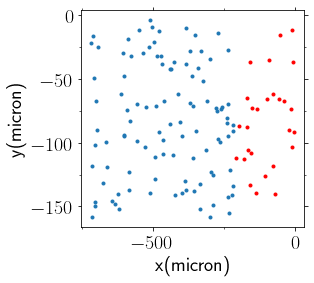

In [16]:
print('test/train split ...')

mask = np.all(~np.isnan(disps),axis=1) #--- indented grains
#
train_test_mask  = train_test_set_split( mask,
                             random_state=128,
                             test_size=.3, train_size=.7)

#--- train-test split (structured)
print('train set (blue) and test set (red):')
train_test_mask.train_test_split_structured(np.c_[df_attributes[['x','y']]])
train_test_mask.Plot(df_attributes,
             train_test_mask.train_mask,
             train_test_mask.test_mask)

# Training

In [ ]:
#--- set training parameters
num_processing_steps_tr = 3
num_training_iterations = 10000
learning_rate           = 1.0e-3 
node_output_size        = len(target_nodes_np[0])
train_mask              = tf.constant(train_test_mask.train_mask, dtype=tf.bool)
test_mask               = tf.constant(train_test_mask.test_mask , dtype=tf.bool)
target_nodes            = tf.constant(target_nodes_np)
train_mask_np           = train_test_mask.train_mask
test_mask_np            = train_test_mask.test_mask


model                   = EncodeProcessDecode(node_output_size=len(target_nodes_np[0]))
        
#--- training base graph
output_ops, latent_ops  = model(input_graph, num_processing_steps_tr)

#--- Training loss.
loss_op_tr              = []
loss_op_ts              = []

for op in output_ops:
    loss_op_tr.append( create_loss_ops(target_nodes, op, train_mask,None))
    loss_op_ts.append( create_loss_ops(target_nodes, op, test_mask,None))

#--- Training loss across processing steps.
loss_op_tr_sum          = sum(loss_op_tr) / num_processing_steps_tr


#--- Optimizer
optimizer               = tf.train.AdamOptimizer(learning_rate)
step_op                 = optimizer.minimize(loss_op_tr_sum)


training_history        = np.zeros((num_training_iterations, 2*num_processing_steps_tr)) 
correlat_history        = np.zeros((num_training_iterations, 2*num_processing_steps_tr)) 
counter                 = 0


#--- This cell resets the Tensorflow session, but keeps the same computational
#--- graph.
try:
  sess.close()
except NameError:
  pass
sess                    = tf.Session()
sess.run(tf.global_variables_initializer())
#print(snt.format_variables(model.variables))

best_val_loss           = np.inf
best_val_loss_all       = np.inf*np.ones(num_processing_steps_tr)
last_improved           = 0
early_stopping_crit     = num_training_iterations

measure_val_by_loss     = True
print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

# #--- training loop
for iteration in range(num_training_iterations):
    last_iteration      = iteration
    train_values        = sess.run({
                                    "step": step_op,
                                    "loss": loss_op_tr,
                                    "outputs": output_ops,
                                    "latents": latent_ops,
    })


    test_values         = sess.run({
                                    "loss_test": loss_op_ts,
    })

    #--- store losses at each iteration: training_history[counter]=[train_loss,test_loss]
    training_history[counter, 0:num_processing_steps_tr] = train_values['loss']
    training_history[counter, num_processing_steps_tr:]  = test_values['loss_test']

    #--- print loss corresponding to the last block
    if(iteration+1) %100==0:
        print("%s, training %3.2e, test %3.2e, best loss %3.2e"
              %(iteration+1,training_history[counter,num_processing_steps_tr-1], 
                training_history[counter,-1], 
                best_val_loss ))

        for i in range(num_processing_steps_tr):
            if measure_val_by_loss:
                cond      =      (training_history[counter,num_processing_steps_tr+i] < best_val_loss_all[i]) #--- training
                cond_best = (training_history[counter,num_processing_steps_tr+i] < best_val_loss)
            if cond:
                step_output =  sess.run(output_ops[i].nodes) 

                best_val_loss_all[i]  = training_history[counter,num_processing_steps_tr+i] #--- training
            if cond_best:
                assert cond
                best_output    = np.copy(step_output)
                best_latent    = sess.run(latent_ops[i])
                best_val_loss  = training_history[counter,num_processing_steps_tr+i] #--- test
                last_improved  = counter


    counter+=1 
    if counter > last_improved + early_stopping_crit:
        print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
        break


training_history = training_history[:counter]
for i in range(num_processing_steps_tr):
    latest_output =  sess.run(output_ops[i].nodes) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
MEASURE VALIDATION BY LOSS  True
100, training 7.41e+04, test 2.53e+04, best loss inf
200, training 7.34e+04, test 2.48e+04, best loss 2.53e+04
300, training 7.25e+04, test 2.41e+04, best loss 2.48e+04
400, training 7.13e+04, test 2.32e+04, best loss 2.41e+04
500, training 6.99e+04, test 2.22e+04, best loss 2.32e+04
600, training 6.83e+04, test 2.10e+04, best loss 2.22e+04
700, training 6.65e+04, test 1.97e+04, best loss 2.10e+04
800, training 6.46e+04, test 1.84e+04, best loss 1.97e+04
900, training 6.26e+04, test 1.69e+04, best loss 1.84e+04
1000, training 6.05e+04, test 1.55e+04, best loss 1.69e+04


In [ ]:
mse_test  = mean_squared_error( np.array(target_nodes_np)[test_mask_np].flatten(),
                                np.array(best_output[test_mask_np]).flatten())
mse_train = mean_squared_error( np.array(target_nodes_np)[train_mask_np].flatten(),
                                np.array(best_output[train_mask_np]).flatten())


We'll plot the learning rate associated with the training and test sets here.

In [ ]:
iproc  = 2
legend = Legends()
legend.Set()
ax     = PltErr(range(training_history.shape[0]),
           training_history[:,0*num_processing_steps_tr+iproc],
           attrs={'fmt':'x','label':'training'},
           xscale='log',
           yscale='log',
              Plot=False,
          )

PltErr(range(training_history.shape[0]),
           training_history[:,1*num_processing_steps_tr+iproc],
           attrs={'fmt':'x','label':'test'},
           xscale='log',
           yscale='log',
           ax=ax,
           legend=legend.Get(),
           xstr='epoch',
           ystr='mse',
          )

